In [1]:
import pandas as pd
import numpy as np
import sys

sys.path.append('../../src')
from ecomplexity import ecomplexity
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
import io

import matplotlib.ticker as ptick
import networkx as nx
import networkx.algorithms.bipartite as bip

plt.rcParams['font.family'] = 'Meiryo'
plt.rcParams['font.size'] = 20

# 小数点以下 桁数 6
pd.options.display.float_format = '{:.3f}'.format


In [2]:
import initial_condition
from process import weight
from visualize import rank as vr

In [3]:
global data_dir, ex_dir, output_dir
data_dir = '../../data/processed/internal/technology/'
ex_dir = '../../data/processed/external/'
output_dir = '../../output/figures/'

In [7]:
# 初期条件
ar = initial_condition.AR
year_style = initial_condition.YEAR_STYLE

year_start = initial_condition.YEAR_START
year_end = initial_condition.YEAR_END
year_range = initial_condition.YEAR_RANGE

extract_population = initial_condition.EXTRACT_POPULATION

top_p_or_num = {'right_person_name': ('p', 3), 'right_person_addr': ('p', 100)}
# region_corporation = initial_condition.REGION_CORPORATION

applicant_weight = initial_condition.APPLICANT_WEIGHT

classification = initial_condition.CLASSIFICATION
class_weight = initial_condition.CLASS_WEIGHT

color_list = initial_condition.COLOR_LIST


input_condition_dict = {region_corporation:f'{ar}_{year_style}_{extract_population}_{top_p_or_num[region_corporation][0]}_{top_p_or_num[region_corporation][1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}' 
                        for region_corporation in ['right_person_name', 'right_person_addr']}
fig_name_base_dict = {region_corporation:f'{ar}_{year_style}_{extract_population}_{top_p_or_num[region_corporation][0]}_{top_p_or_num[region_corporation][1]}_{region_corporation}_{applicant_weight}_{classification}_{class_weight}.png'
                      for region_corporation in ['right_person_name', 'right_person_addr']}


In [6]:
period_order_dict = {
    f'{period_start}-{period_start+year_range-1}': i
    for i, period_start in enumerate(range(year_start, year_end + 1, year_range))
}

period_order_dict[f'{year_start}-{year_end}'] = len(period_order_dict)
period_order_dict

{'1981-1990': 0, '1991-2000': 1, '2001-2010': 2, '1981-2010': 3}

In [15]:
dfs_dict = {}
for region_corporation, input_condition in input_condition_dict.items():
    df = pd.read_csv(data_dir + f'{input_condition}.csv', encoding='utf-8',
                    sep=',')
    dfs_dict[region_corporation] = df



In [34]:
name_addr_df = pd.merge(dfs_dict['right_person_name'][[f'{ar}_{year_style}_period', classification, 'tci']]\
                            .rename(columns={'tci': 'tci_name'}), 
                        dfs_dict['right_person_addr'][[f'{ar}_{year_style}_period', classification, 'tci']]\
                            .rename(columns={'tci': 'tci_addr'}),
                        on=[f'{ar}_{year_style}_period', classification], how='inner')
name_addr_df = name_addr_df[name_addr_df[f'{ar}_{year_style}_period'] == f'{year_start}-{year_end}']\
                           .sort_values(by='tci_name', ascending=False).reset_index(drop=True)

In [35]:
name_addr_df

,app_nendo_period,schmoch35,tci_name,tci_addr
0,1981-2010,Pharmaceuticals,1.641,-1.654
1,1981-2010,Organic fine chemistry,1.586,-0.947
2,1981-2010,Food chemistry,1.428,-0.742
3,1981-2010,Biotechnology,1.352,-0.933
4,1981-2010,"Macromolecular chemistry, polymers",1.306,-1.537
5,1981-2010,Basic materials chemistry,1.176,-1.415
6,1981-2010,Analysis of biological materials,1.081,-0.575
7,1981-2010,Other special machines,0.871,-1.379
8,1981-2010,Chemical engineering,0.860,-1.426
9,1981-2010,"Materials, metallurgy",0.769,-1.210


1981-2010 -0.905


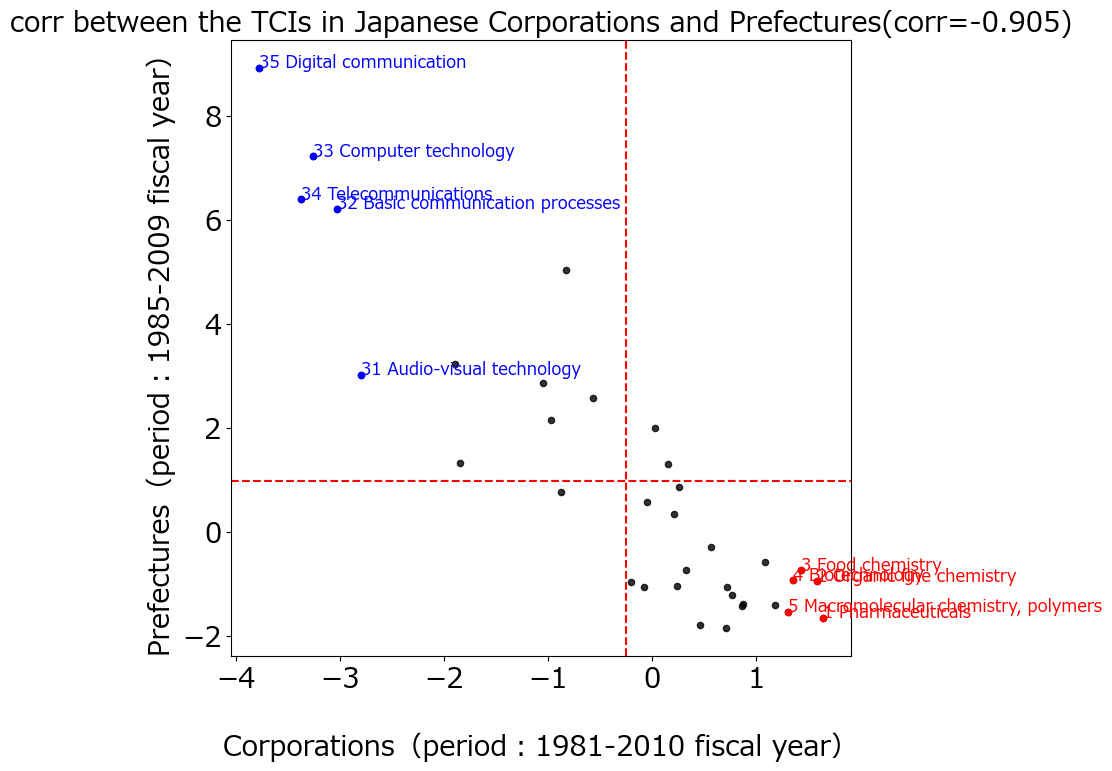

In [37]:
df_dict = {}
combi_dict = {  # ind: [x, y, title, xlabel, ylabel, legend_loc]
    1: ["tci_name", "tci_addr", "corr between the TCIs in Japanese Corporations and Prefectures", "Corporations（period：1981-2010 fiscal year）", "Prefectures（period：1985-2009 fiscal year）", "center", ],
    # 1: ["TCI_jp", "TCI_eu", "corr between the TCIs in Japan and EU", "Japan（period：1981-2010 fiscal year）", "EU（period：1985-2009 year）", "center", ],
    # 2: ["reg_num_jp", "reg_num_eu", "corr between the patent amounts in Japan and EU", "Japan（period：1981-2010 fiscal year）", "EU（period：1985-2009 year）", "center", ],
    # 3: ["reg_num_jp", "TCI_jp", "corr between the patent amounts in Japan and TCI in Japan", "Japan（period：1981-2010 fiscal year）", "Japan（period：1981-2010 fiscal year）", "center", ],
    # 4: ["reg_num_eu", "TCI_eu", "corr between the patent amounts in EU and TCI in EU", "EU（period：1985-2009 year）", "EU（period：1985-2009 year）", "center", ],
    # 2: ["TCI_eu", "TCI_jp", "corr between the TCIs in Japan and EU", "EU（period：1985-2009 year）", "Japan（period：1981-2010 fiscal year）", "center", ],
}
plt.rcParams['font.size'] = 20
plt.rcParams['font.family'] = 'Meiryo'
for i, combi in combi_dict.items():
    fig, ax = plt.subplots(figsize=(8, 8))
    period = f"{year_start}-{year_end}"
    corr_num = round(name_addr_df[combi[0]].corr(name_addr_df[combi[1]]), 3)
    print(period, corr_num)
    ax.scatter(name_addr_df[combi[0]], name_addr_df[combi[1]],
               s=20, alpha=0.8, color="black", )
    # if i == 4:
    ax.axvline(x=name_addr_df[combi[0]].mean(), color="red", linestyle="--", )
    ax.axhline(y=name_addr_df[combi[1]].mean(), color="red", linestyle="--", )
    ax.set_title(combi[2]+f'(corr={corr_num})', fontsize=20)
    if combi[0] in ["reg_num"]: ax.set_xscale("log")
    if combi[1] in ["reg_num"]: ax.set_yscale("log")
    x_min = name_addr_df[combi[0]].min()
    x_2smallest = (name_addr_df[combi[0]].nsmallest(2).iloc[1])
    y_2smallest = (name_addr_df[combi[1]].nsmallest(2).iloc[1])
    head_df = name_addr_df.head(5)
    between_df = name_addr_df.iloc[5:len(name_addr_df)-5, :]
    tail_df = name_addr_df.tail(5)
    if i != 5:
        for i, row in head_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=12, color="red")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
        # for i, row in between_df.iterrows():
        #     ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=12, color="black")
        #     ax.scatter(row[combi[0]], row[combi[1]], s=20, color="black")
        for i, row in tail_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], f'{i+1} {row["schmoch35"]}', fontsize=12, color="blue", )
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    elif i == 2:
        for i, row in head_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=12, color="red")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="red")
        for i, row in between_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=12, color="black")
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="black")
        for i, row in tail_df.iterrows():
            ax.text(row[combi[0]], row[combi[1]], i+1, fontsize=12, color="blue", )
            ax.scatter(row[combi[0]], row[combi[1]], s=20, color="blue")
    ax.set_ylabel(combi[4], fontsize=20)
    ax.set_xlabel('\n'+combi[3], fontsize=20)
    # ax.legend(loc=combi[5], fontsize=20, bbox_to_anchor=(1.05, 1), borderaxespad=0)
    plt.show()
